In [1]:
import os  # Import the os module for operating system related functionalities

import torch  # Import the torch module for deep learning functionalities
import torchvision  # Import the torchvision module for computer vision tasks
import torchvision.transforms as transforms  # Import the transforms module for data transformations

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    

def restrict_GPU_pytorch(gpuid, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        print("Using GPU:{}".format(gpuid))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

restrict_GPU_pytorch('2,6,7')

Using GPU:2,6,7


In [2]:
# Get models
model_names = ['ResNet50', 'ResNet101', 'ResNet152']

models = [torchvision.models.resnet50(pretrained=True, progress=True),
          torchvision.models.resnet101(pretrained=True, progress=True),
          torchvision.models.resnet152(pretrained=True, progress=True)]

dataset_name = 'ImageNet'



# Get dataloader for ImageNet
transforms_list = [transforms.Resize(size=256),
                    transforms.CenterCrop(size=224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                   ]
transform = transforms.Compose(transforms_list)
dataset = ImageFolderWithPaths("/data/ddmg/prism/conformal_prediction/data/imagenet/val/", transform = transform)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)

/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also 

In [3]:
import numpy as np
from tqdm.notebook import tqdm
# Generate predictions for each model
# Eventually we will want to write out files containing model predictions
# for each model x dataset we consider.

import os
import numpy as np

model_pred_labels_path = '/data/ddmg/frank/shuvom/pred_matrices/model_pred_labels.npy'
true_labels_path = '/data/ddmg/frank/shuvom/pred_matrices/true_labels.npy'
need_to_run = False

if need_to_run:
    n_models = len(models)
    n_examples = len(dataloader.dataset)
    model_pred_labels = np.zeros((n_examples, n_models))
    for j, model in enumerate(models):
        print("Model: {}".format(model_names[j]))
        
        model.cuda()
        model.eval()
        
        outputs = []
        labels = []
        for i, batch in tqdm(enumerate(dataloader)):
            inputs = batch[0].cuda()
            batch_label = batch[1]     

            batch_output = model(inputs.float()).detach().cpu().numpy()

            outputs.append(batch_output)
            labels.append(batch_label)
            
        # Removing model from GPU to make space for the next one
        model.to(torch.device('cpu'))
        outputs = np.concatenate(outputs, axis=0)
        true_labels = np.concatenate(labels)
        
        # Only saving out the top prediction to save space 
        pred_labels = np.argmax(outputs, axis=1)
        model_pred_labels[:,j] = pred_labels
        
        torch.cuda.empty_cache()
        
    np.save(true_labels_path, true_labels)

else:
    model_pred_labels = np.load(model_pred_labels_path)
    true_labels = np.load(true_labels_path)
    selected_classes = np.load('/data/ddmg/frank/shuvom/pred_matrices/selected_classes.npy')
    error_rates_ds = np.load('/data/ddmg/frank/shuvom/pred_matrices/ds_error_rates_all_classes.npy')


In [4]:
if need_to_run:
    diff_predictions = np.sum(np.diff(model_pred_labels, axis=1) != 0, axis=1)
    num_diff_predictions = np.sum(diff_predictions > 0)
    print(f'Number of rows where not all three models have the same prediction: {num_diff_predictions}')

    from itertools import combinations

    n_models = len(models)
    # Generate all pairs of models
    model_pairs = list(combinations(range(n_models), 2))

    # For each pair of models, print the number of disagreements
    for pair in model_pairs:
        disagreements = np.sum(model_pred_labels[:, pair[0]] != model_pred_labels[:, pair[1]])
        print(f'Number of disagreements between model {pair[0]} and model {pair[1]}: {disagreements}')

    # np.save('/data/ddmg/frank/shuvom/pred_matrices/model_pred_labels.npy', model_pred_labels)

    true_labels = np.array(true_labels).astype(int)


    # subsample the dataset for speed
    sample_idxs = np.random.choice(list(range(50000)), replace=False, size=2000)
    # sampled_outputs = outputs[sample_idxs]
    sampled_labels = true_labels[sample_idxs]
    sampled_pred_labels = model_pred_labels[sample_idxs]




In [5]:
print(error_rates_ds.shape)
print(selected_classes.shape)
print(true_labels.shape)
print(model_pred_labels.shape)

from collections import Counter
label_counts = Counter(true_labels)
# print(label_counts)


(100, 3, 2, 2)
(100,)
(50000,)
(50000, 3)


Model: ResNet-50
Model accuracy: [2.0000e-05 4.0000e-05 6.0000e-05 ... 9.9984e-01 9.9992e-01 9.9998e-01]


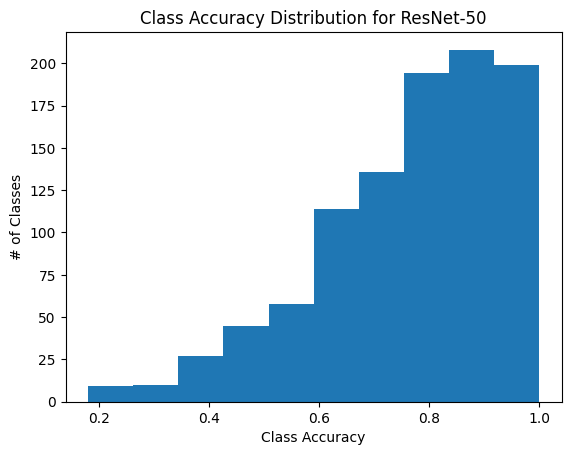

In [6]:
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# import matplotlib.pyplot as plt
# Model accuracy
model_idx = 0
model_name = 'ResNet-50'
acc = np.where(model_pred_labels[:,model_idx] == true_labels)[0]/len(true_labels)

# Class-specific accuracy for each model
n_classes = 1000
class_accs = [] 
for i in range(n_classes):
    class_accs.append(np.mean(model_pred_labels[:,model_idx][true_labels == i] == i))
plt.hist(class_accs)
plt.xlabel("Class Accuracy")
plt.ylabel("# of Classes")
plt.title(f"Class Accuracy Distribution for {model_name}")
# i.e. for each class, which model is the best.

print(f'Model: {model_name}')
print(f'Model accuracy: {acc}')

In [8]:
# Generate a n examples x n models x n classes matrix 
# where one_hot_model_predictions[i][j][k] = 1 if model j predicts example i to be class k 
n_examples = len(sampled_pred_labels)


model_predictions = []  # Initialize an empty list to store model predictions
for i in range(3):  # Loop over the three models
    pred_labels = sampled_pred_labels[:,i]  # Get the predicted labels for the current model
    one_hot_pred_labels = np.zeros((n_examples, 1000))  # Initialize a one-hot encoded array for the predicted labels
    one_hot_pred_labels[list(range(n_examples)), pred_labels.astype(int)] = 1  # One-hot encode the predicted labels
    model_predictions.append(one_hot_pred_labels)  # Append the one-hot encoded predictions to the list
one_hot_predictions_all_classes = np.stack(model_predictions, axis = 1)  # Stack the one-hot encoded predictions for all models


NameError: name 'sampled_pred_labels' is not defined

In [17]:
import numpy as np

need_to_run = True
if need_to_run:
    # The following code is the original code, commented out as per the instructions
    # class_idx = 1 
    # one_hot_preds_one_class = []
    # n_classes = 2
    # n_examples = len(model_pred_labels)
    # for i in range(3):
    #     one_hot_one_class = np.zeros((n_examples, n_classes))
    #     one_class_preds = (model_pred_labels[:,i] == class_idx).astype(int)
    #     one_hot_one_class[list(range(n_examples)),one_class_preds] = 1
    #     one_hot_preds_one_class.append(one_hot_one_class)
    # one_hot_predictions_one_class = np.stack(one_hot_preds_one_class, axis = 1)
    # one_hot_predictions_one_class.shape

    # class_idx = 1 
    # binarized_model_predictions = []
    # for i in range(3):
    #     binary_model_predictions = (model_pred_labels[:,i] == class_idx).astype(int)
    #     binarized_model_predictions.append(binary_model_predictions)
    # binarized_model_predictions = np.stack(binarized_model_predictions, axis=1)
    # binarized_model_predictions.shape

    # from dawid_skene import run
    # This is really slow because there are so many classes. 
    # We could also make this easier by turning ImageNet into a binary problem for a particular class.
    # _, _, _, _, _, error_rates, _ = run(one_hot_predictions_one_class)
    # selected_classes = np.random.choice(range(1000), size=100, replace=False)

    error_rates_all_classes = []  # Initialize a list to store error rates for all classes
    # num_classes = 100

    for idx, class_idx in enumerate(selected_classes):  # Loop over selected classes
        print(f'\rProcessing class: {class_idx}, number: {idx}', end='')  # Print the current class index with rolling output
        one_hot_preds_one_class = []
        n_classes = 2
        n_examples = len(model_pred_labels)
        for i in range(3):
            one_hot_one_class = np.zeros((n_examples, n_classes))
            one_class_preds = (model_pred_labels[:,i] == class_idx).astype(int)
            one_hot_one_class[list(range(n_examples)),one_class_preds] = 1
            one_hot_preds_one_class.append(one_hot_one_class)
        one_hot_predictions_one_class = np.stack(one_hot_preds_one_class, axis = 1)

        binarized_model_predictions = []
        for i in range(3):
            binary_model_predictions = (model_pred_labels[:,i] == class_idx).astype(int)
            binarized_model_predictions.append(binary_model_predictions)
        binarized_model_predictions = np.stack(binarized_model_predictions, axis=1)

        import importlib
        import dawid_skene
        importlib.reload(dawid_skene)
        from dawid_skene import run
        import sys
        import os
        
        mute_print = False 
        if mute_print:
            with open(os.devnull, 'w') as f:
                # Save the current stdout
                old_stdout = sys.stdout
                # Set stdout to the dummy file
                sys.stdout = f
                # Run the function with print statements muted
                _, _, _, _, _, error_rates, _ = run(one_hot_predictions_one_class)
                # Restore stdout
                sys.stdout = old_stdout
        else:
            run(one_hot_predictions_one_class)
        # error_rates_all_classes.append(error_rates)  # Append the error rates for the current class to the list
        if idx > 2:
            break




Processing class: 901, number: 0num Patients: 50000
Observers: [0, 1, 2]
Classes: [0, 1]


array([[0.96666884, 0.96667395, 0.90625607],
       [0.92309546, 0.70591742, 0.75000518],
       [0.88638058, 0.95123403, 0.90698919],
       [0.93333931, 0.97674851, 0.99999996],
       [1.        , 0.95454543, 0.99999997],
       [0.99999998, 0.9791699 , 0.99999999],
       [0.97872336, 0.99999991, 0.97872336],
       [0.8648728 , 0.86488072, 0.80000695],
       [0.78217783, 0.96666657, 0.86666746],
       [0.93877707, 0.93877847, 0.95833862],
       [0.90476726, 0.97438286, 0.97436536],
       [0.92307767, 0.99999999, 0.94737562],
       [0.99999997, 0.94827746, 0.99999999],
       [0.93333895, 0.99999995, 0.93334094],
       [0.91176586, 0.96875087, 0.96875331],
       [0.97727438, 0.97727614, 0.99999997],
       [0.73685215, 0.8236003 , 0.73686973],
       [0.88373191, 0.88374239, 0.92684637],
       [0.96876109, 0.91177977, 0.8378535 ],
       [0.97872336, 0.97872336, 0.99999991],
       [0.9428596 , 0.97059116, 0.91666797],
       [0.94118865, 0.96971065, 0.84211461],
       [0.

In [8]:
# error_rates_all_classes = np.array(error_rates_all_classes)  # Convert the list to a numpy array
# np.save('/data/ddmg/frank/shuvom/pred_matrices/ds_error_rates_all_classes.npy', error_rates_all_classes)  # Save the error rates
# np.save('/data/ddmg/frank/shuvom/pred_matrices/selected_classes.npy', selected_classes)  # Save the selected classes


### Dawid-Skene

In [9]:
# n_classes
# model_per_class_accuracy = []
# for model_idx in range(n_models):
#     model_accuracy = []
#     for class_idx in selected_classes:
#         true_labels_class = (true_labels == class_idx).astype(int)
#         model_pred_labels_class = (model_pred_labels[:, model_idx] = class_idx).astype(int)
#         accuracy = np.mean(true_labels_class == model_pred_labels_class)
#         model_accuracy.append(accuracy)
#     model_per_class_accuracy.append(model_accuracy)

# model_per_class_accuracy = np.array(model_per_class_accuracy)
# print('Model per class accuracy:', model_per_class_accuracy)

# model_pred_labels.shape
# for class_idx in selected_classes:
#     # Error rates for each of the models, for this class. 
#     model_accuracy = error_rates_all_classes[class_idx, :, 1, 1]  # Extract the accuracy of each model for the class
#     model_rankings = model_accuracy.argsort() + 1  # Rank the models for the class

#     # Create a dictionary to store the frequency of each ranking
#     ranking_dict = {tuple(i): 0 for i in itertools.permutations(range(1, len(model_names) + 1))}

#     # Count the frequency of each ranking
#     for ranking in model_rankings:
#         ranking_dict[tuple(ranking)] += 1

#     # Calculate the relative frequency of each ranking
#     relative_frequency = {k: v / np.sum(list(ranking_dict.values())) for k, v in ranking_dict.items()}

#     # Plot a histogram of the relative frequency of all rankings
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(len(relative_frequency)), list(relative_frequency.values()), align='center')
#     plt.xticks(range(len(relative_frequency)), list(relative_frequency.keys()))
#     plt.xlabel('Ranking')
#     plt.ylabel('Relative Frequency')
#     plt.title(f'Histogram of Relative Frequency of All Rankings for Class {class_idx}')
#     plt.show()


In [18]:
# # error_rates_all_classes.shape

# error_rates_all_classes

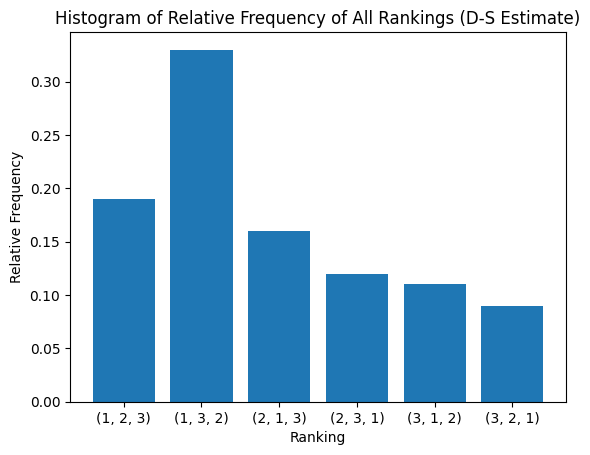

In [7]:
# Error rates for each of the models, for this class. 
model_accuracy_ds = error_rates_ds[:, :, 1, 1]  # Extract the accuracy of each model for each class
model_rankings = model_accuracy_ds.argsort(axis=1) + 1  # Rank the models for each class

# print(model_accuracy)
# Store the rankings
# np.save('/data/ddmg/frank/shuvom/pred_matrices/model_rankings.npy', model_rankings)


import matplotlib.pyplot as plt
import itertools


# Create a dictionary to store the frequency of each ranking
ranking_dict_ds = {tuple(i): 0 for i in itertools.permutations(range(1, len(model_names) + 1))}

# Count the frequency of each ranking
for ranking in model_rankings:
    ranking_dict_ds[tuple(ranking)] += 1

# Calculate the relative frequency of each ranking
relative_frequency = {k: v / np.sum(list(ranking_dict_ds.values())) for k, v in ranking_dict_ds.items()}

# Plot a histogram of the relative frequency of all rankings
plt.bar(range(len(relative_frequency)), list(relative_frequency.values()), align='center')
plt.xticks(range(len(relative_frequency)), list(relative_frequency.keys()))
plt.xlabel('Ranking')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Relative Frequency of All Rankings (D-S Estimate)')
plt.show()


# model_rankings.flatten()


In [8]:
# np.sum(np.abs(model_rankings - model_rankings_ds), axis=1)
# np.sum(np.abs(model_rankings - model_trues)[:,2] == 0)

# class_idx = selected_classes[3]
# model_predictions = model_pred_labels[true_labels == class_idx]

# np.sum(model_predictions != class_idx, axis=0)

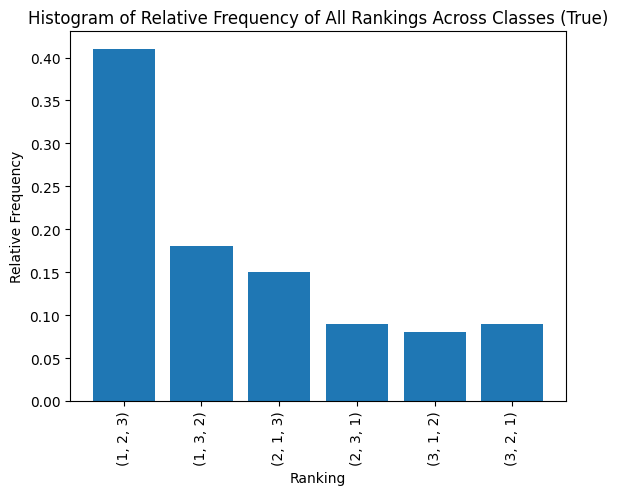

In [8]:
import collections
import itertools

# Create a list to store the rankings of all classes
ranking_dict_true = {tuple(i): 0 for i in itertools.permutations(range(1, len(model_names) + 1))}
model_trues = []
largest_gaps = []
valid_orderings = 0
ties = 0

# Create a list to store all model error rates
all_model_error_rates = []

for i, class_idx in enumerate(selected_classes):
    # Extract the predictions of each model for this class
    model_predictions = model_pred_labels[true_labels == class_idx]
    
    
    # Calculate the accuracy for this class
    model_error_rates = np.mean(model_predictions == class_idx, axis=0)

    # Add the error rates to the list
    all_model_error_rates.append(model_error_rates)

    # largest_gaps.append(model_error_rates.max() - sorted(model_error_rates)[-2])
    # largest_gaps.append(model_error_rates.max() - model_error_rates.min())
    largest_gaps.append(model_error_rates[0] - model_error_rates[2])
    # Initialize a counter for valid orderings
    

    # Check if model_rankings[i] is a valid ordering of model_error_rates from least to greatest
    
    if len(set(model_error_rates)) == 1:
        # print("All models have the same error rate for this class.")
        ties += 1

    elif len(set(model_error_rates)) == 2:
        # print("Exactly two models have the same error rate for this class.")
        ties += 1
    

        
    # Rank the models for this class
    model_rankings_true = model_error_rates.argsort() + 1
    model_trues.append(model_rankings_true)
    
    # Add the rankings to the list
    # all_class_rankings.append(tuple(model_rankings))
    ranking_dict_true[tuple(model_rankings_true)] += 1


# Count the frequency of each ranking
relative_frequency = {k: v / np.sum(list(ranking_dict_true.values())) for k, v in ranking_dict_true.items()}


# Plot a histogram of the relative frequency of all rankings
plt.bar(range(len(relative_frequency)), list(relative_frequency.values()), align='center')
plt.xticks(range(len(relative_frequency)), [str(k) for k in relative_frequency.keys()], rotation=90)
plt.xlabel('Ranking')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Relative Frequency of All Rankings Across Classes (True)')
plt.show()



In [13]:
# np.save('/data/ddmg/frank/shuvom/pred_matrices/all_model_error_rates.npy', all_model_error_rates)

In [10]:
# matching_indices_count = np.sum(model_rankings_ds == model_rankings_true)
# print("Number of matching indices: ", matching_indices_count)
# plt.hist(largest_gaps, bins=20, alpha=0.5)
# plt.title('Histogram of top two gaps')
# plt.xlabel('gap size')
# plt.ylabel('frequency')
# plt.show()

import json
# model_error_rates
largest_gaps_indices = np.argpartition(largest_gaps, -10)[-10:]
for index in largest_gaps_indices:
    print(largest_gaps[index])

# print(largest_gaps[list(largest_gaps_indices])
selected_classes_largest_gaps = selected_classes[largest_gaps_indices]


with open('imagenet-simple-labels.json') as f:
    labels = json.load(f)

# print(labels)
def class_id_to_label(i):
    return labels[i]

for i in selected_classes_largest_gaps:
    print(class_id_to_label(i))
    

# print(class_id_to_label(924))

0.040000000000000036
0.07999999999999996
0.07999999999999996
0.06000000000000005
0.09999999999999998
0.10000000000000009
0.06
0.06000000000000005
0.05999999999999994
0.05999999999999994
sea anemone
reflex camera
promontory
grand piano
Kuvasz
cliff
ear
smooth green snake
Mexican hairless dog
Groenendael


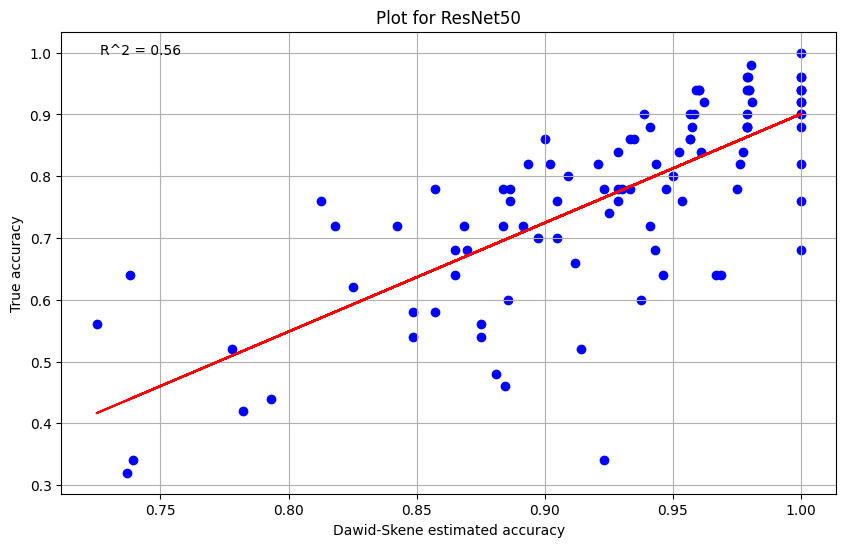

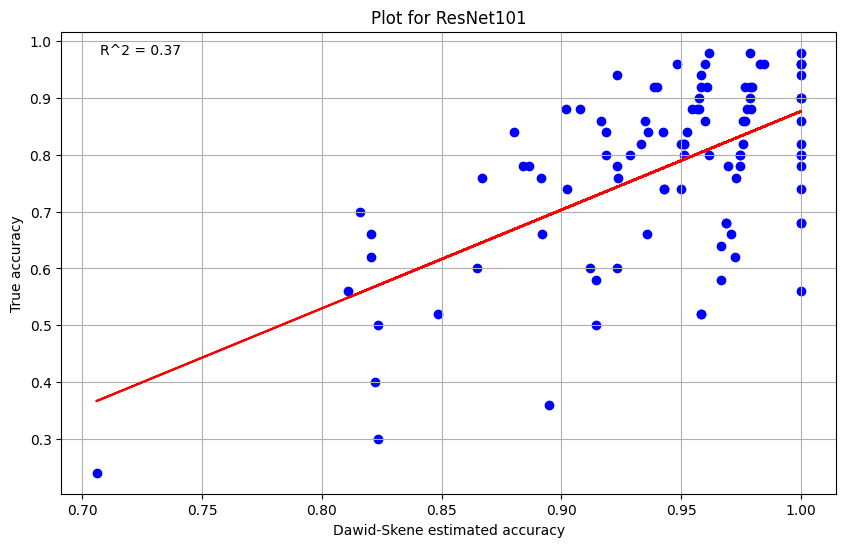

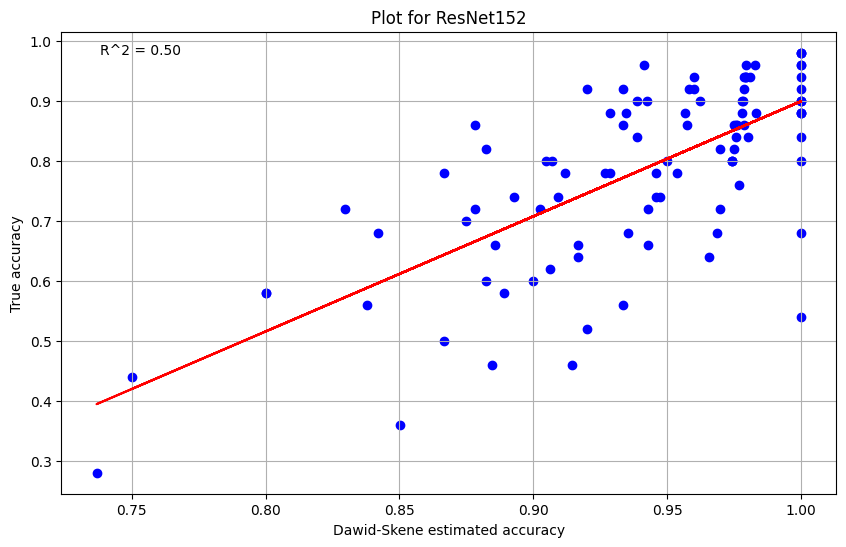

In [11]:
# model_rankings_ds
# np.corrcoef(model_accuracy_ds[:,0], np.roll(np.array(all_model_error_rates)[:,0], 2))
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats


for i in range(3):
    x = model_accuracy_ds[:,i]
    y = np.roll(np.array(all_model_error_rates)[:,i],0)
    
    plt.figure(figsize=(10,6))
    plt.scatter(x, y, color='blue')
    
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    plt.plot(x, line, color='red')
    
    plt.title(f'Plot for {model_names[i]}')
    plt.xlabel('Dawid-Skene estimated accuracy')
    plt.ylabel('True accuracy')
    plt.grid(True)
    
    r2 = r2_score(y, line)
    plt.text(0.05, 0.95, f'R^2 = {r2:.2f}', transform=plt.gca().transAxes)
    
    plt.show()




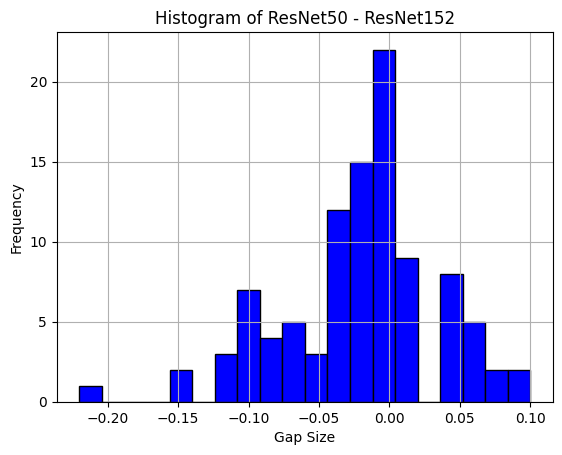

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'largest_gaps' is a list or numpy array containing the values of the largest gaps
plt.hist(largest_gaps, bins=20, color='blue', edgecolor='black')
plt.title('Histogram of ResNet50 - ResNet152')
plt.xlabel('Gap Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# from dawid_skene import run
# # This is really slow because there are so many classes.
# run(one_hot_model_predictions)

num Patients: 2000
Observers: [0, 1, 2]
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 

### Walter & Lui

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from torch import nn
from torch.autograd import Variable
# import pdb

# import torch

import pandas as pd
import seaborn as sns
sns.set_style('white')

# Alpha and beta control class-specific error rates; 
# alpha is the  false negative rate
# beta is the false positive rate
# I create classifiers with certain FNRs / FPRs but simulating different alphas & betas on the train set

def apply_alpha_beta(y, alpha_opt, beta_opt):
    t = y.copy()
    for label in [0, 1]:
        n_examples = (t == label).sum()
        swap_rate = alpha_opt if label == 0 else beta_opt
        swap_idxs = np.random.choice(np.where(t == label)[0], size=int(swap_rate * n_examples), replace=False)
        t[swap_idxs] = 1 - label
    return t

def inv_sigm(y):
    return np.log(y / (1 - y))

def gibbs_classification(model, x):
    p_y = model.predict_proba(x)[:,1]
    samples = np.random.random(p_y.shape)
    return (samples  < p_y).astype(int)

def get_agreements(*tests):
    # tests are binary outputs from classifiers
    # This function calculates the number of agreements between the classifiers
    # for all possible combinations of positive and negative results
    
    # Initialize a dictionary to store the results
    agreements = {}
    
    # Get the indices of positive and negative results for each test
    pos_indices = [np.where(test == 1)[0] for test in tests]
    neg_indices = [np.where(test == 0)[0] for test in tests]
    
    # Calculate the number of agreements for all combinations
    for i in range(2 ** len(tests)):
        # Convert the combination to binary and pad with zeros
        combination = bin(i)[2:].zfill(len(tests))
        
        # Get the indices for this combination
        indices = [pos_indices[j] if combination[j] == '1' else neg_indices[j] for j in range(len(tests))]
        
        # Calculate the number of agreements
        agreements[combination] = len(set(indices[0]).intersection(*indices[1:]))
    
    return agreements

'''
def get_agreements_old(tA, tB, tC):
    # tA, tB, and tC are binary outputs from classifiers  A, B, and C respectively
    tA_pos = np.where(tA == 1)[0]
    tA_neg = np.where(tA == 0)[0]
    tB_pos = np.where(tB == 1)[0]
    tB_neg = np.where(tB == 0)[0]
    tC_pos = np.where(tC == 1)[0]
    tC_neg = np.where(tC == 0)[0]
    n_tA_pos, n_tA_neg = len(tA_pos), len(tA_neg)
    n_tB_pos, n_tB_neg = len(tB_pos), len(tB_neg)

    n_pos_pos_pos = len(set(tA_pos).intersection(tB_pos).intersection(tC_pos))
    n_pos_pos_neg = len(set(tA_pos).intersection(tB_pos).intersection(tC_neg))

    n_pos_neg_pos = len(set(tA_pos).intersection(tB_neg).intersection(tC_pos))
    n_pos_neg_neg = len(set(tA_pos).intersection(tB_neg).intersection(tC_neg))

    n_neg_pos_pos = len(set(tA_neg).intersection(tB_pos).intersection(tC_pos))
    n_neg_pos_neg = len(set(tA_neg).intersection(tB_pos).intersection(tC_neg))

    n_neg_neg_pos = len(set(tA_neg).intersection(tB_neg).intersection(tC_pos))
    n_neg_neg_neg = len(set(tA_neg).intersection(tB_neg).intersection(tC_neg))
    
    return n_pos_pos_pos, n_pos_pos_neg, n_pos_neg_pos, n_pos_neg_neg, n_neg_pos_pos, n_neg_pos_neg, n_neg_neg_pos, n_neg_neg_neg
'''

In [19]:
# We can't get accurate estimates of alpha or beta for any classifier without additional assumptions about the errors. 
# Also, the assumption that the errors are independent  of x is broken.
# Can we get an ordering of classifiers if we know 1 classifiers specificity?
# But maybe you can get an ordering of classifiers on your data
import itertools
from tqdm.notebook import tqdm
# Sample different alpha, beta, and theta values 
# Train different models 

alpha_opts = [.1, .2, .3]
beta_opts = [.1, .2, .3]
theta_opts = [.1, .3, .5, .7]

alpha_sets = []
for i, alphaA in enumerate(alpha_opts):
    if i > 1:
        continue
    for alphaB in alpha_opts[i+1:]:
        for alphaC in alpha_opts[i+2:]:
            alpha_sets.append((alphaA, alphaB, alphaC))
beta_sets = []
for i,betaA in enumerate(beta_opts):
    for betaB in beta_opts[i+1:]:
        for betaC in beta_opts[i+2:]:
            if betaC == betaB:
                continue
            beta_sets.append((betaA, betaB, betaC))

train_size = 10000
test_size = 20000
n_epochs = 10000
results = []
configs = list(itertools.product(alpha_sets, beta_sets, theta_opts))
for alpha_set, beta_set, true_theta in tqdm(configs):
    true_alphaA, true_alphaB, true_alphaC = alpha_set
    true_betaA, true_betaB, true_betaC = beta_set
    
    pos = np.random.multivariate_normal((1, 1), [[1, 1], [1, 1]], size=train_size)
    neg = np.random.multivariate_normal((-1, -1), [[1, 1], [1, 1]], size=train_size)
    x_train = np.concatenate([pos, neg], axis=0)
    y_train = np.concatenate([np.ones(train_size), np.zeros(train_size)], axis=0)
    models = []
    
    for m_params in [(true_alphaA, true_betaA), 
                     (true_alphaB, true_betaB), 
                     (true_alphaC, true_betaC)]:
        xM_train, yM_train = x_train.copy(), apply_alpha_beta(y_train, m_params[0], m_params[1])
        lrM = LogisticRegression(penalty='none')
        lrM.fit(xM_train, yM_train)
        models.append(lrM)

    # Create test population
    pos_1 = np.random.multivariate_normal((1, 1), [[1, 1], [1, 1]], size=int(true_theta*test_size))
    neg_1 = np.random.multivariate_normal((-1, -1), [[1, 1], [1, 1]], size=int((1-true_theta)*test_size))
    
    x1 = np.concatenate([pos_1, neg_1], axis=0)
    y1 = np.concatenate([np.ones(pos_1.shape[0]), np.zeros(neg_1.shape[0])])
    
    model_preds = [gibbs_classification(model, x1) for model in models]
    nPPP, nPPN, nPNP, nPNN,  nNPP, nNPN, nNNP, nNNN = get_agreements_old(*model_preds)
    # print("new agreements", get_agreements(*model_preds))
    # print("old agreements", get_agreements_old(*model_preds))
    # alpha_ranking
    model_names = ['A', 'B', 'C']
    true_alpha_ranking = [model_names[i] for i in np.argsort([true_alphaA, true_alphaB, true_alphaC])]
    true_beta_ranking = [model_names[i] for i in np.argsort([true_betaA, true_betaB, true_betaC])]
    
    alphaA_v, alphaB_v, alphaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True) for i in range(3)]
    betaA_v, betaB_v, betaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True) for i in range(3)]
    theta1_v = Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True)
    
    # why do we know betaC_v?
    # # We know betaC_v, or the 
    # betaC_v.requires_grad = False
    # betaC_v[0] = inv_sigm(1 - np.mean(model_preds[2][y1==1]))
    # betaC_v.requires_grad = False
    learning_rate = 1e-2
    optim = torch.optim.Adam([theta1_v, betaA_v, betaB_v, alphaA_v, alphaB_v, alphaC_v], lr = learning_rate)
    
    for epoch in range(n_epochs):

        optim.zero_grad()
        alphaA, alphaB, alphaC = torch.sigmoid(alphaA_v), torch.sigmoid(alphaB_v), torch.sigmoid(alphaC_v)
        betaA, betaB, betaC = torch.sigmoid(betaA_v), torch.sigmoid(betaB_v), torch.sigmoid(betaC_v)
        theta1 = torch.sigmoid(theta1_v)
        n_1 = len(model_preds[0])
        l = nPPP*torch.log(((theta1 * (1-betaA) * (1-betaB) * (1-betaC)) + ((1-theta1)*alphaA*alphaB*alphaC)))/n_1
        l += nPPN*torch.log(((theta1 * (1-betaA) * (1-betaB) * (betaC)) + ((1-theta1)*alphaA*alphaB*(1-alphaC))))/n_1

        l += nPNP*torch.log((theta1*(1-betaA)*betaB*(1-betaC)) + ((1-theta1)*alphaA*(1-alphaB)*alphaC))/n_1
        l += nPNN*torch.log((theta1*(1-betaA)*betaB*(betaC)) + ((1-theta1)*alphaA*(1-alphaB)*(1-alphaC)))/n_1

        l += nNPP*torch.log(theta1*betaA*(1-betaB)*(1-betaC) +  (1-theta1)*(1-alphaA)*alphaB*alphaC)/n_1
        l += nNPN*torch.log(theta1*betaA*(1-betaB)*(betaC) +  (1-theta1)*(1-alphaA)*alphaB*(1-alphaC))/n_1

        l += nNNP*torch.log(theta1*betaA*betaB*(1-betaC) + (1-theta1)*(1-alphaA)*(1-alphaB)*alphaC)/n_1
        l += nNNN*torch.log(theta1*betaA*betaB*betaC + (1-theta1)*(1-alphaA)*(1-alphaB)*(1-alphaC))/n_1

        loss = -l
        loss.backward()
        optim.step()
    
    result = {'pred_alphaA': alphaA.item(), 'pred_alphaB': alphaB.item(), 'pred_alphaC': alphaC.item(),
              'pred_betaA': betaA.item(), 'pred_betaB': betaB.item(), 'pred_betaC': betaC.item(),
              'pred_theta1': theta1.item(),
              'true_alphaA': true_alphaA, 'true_alphaB': true_alphaB, 'true_alphaC': true_alphaC,
              'true_betaA': true_betaA, 'true_betaB': true_betaB, 'true_betaC': true_betaC, 'true_theta1': true_theta}
    result['true_alpha_ranking'] = true_alpha_ranking
    result['true_beta_ranking'] = true_beta_ranking
    result['pred_alpha_ranking'] = [model_names[i] for i in np.argsort([result['pred_alphaA'], result['pred_alphaB'],
                                                           result['pred_alphaB']])]
    result['pred_beta_ranking'] = [model_names[i] for i in np.argsort([result['pred_betaA'], result['pred_betaB'],
                                                           result['pred_betaB']])]

    results.append(result)

#  % of time our algorithm ranks the correct method as 1st
# % of time our algorithm ranks the correct method as 2nd
# % of time our algorithm ranks the correct method as 3rd

  0%|          | 0/8 [00:00<?, ?it/s]

/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
 

In [46]:
# all results is indexed by class
all_results = []

for idx, class_idx in enumerate(selected_classes):
    print(f'\rProcessing class: {class_idx}, number: {idx}', end='')  # Print the current class index with rolling output
    one_hot_preds_one_class = []
    n_classes = 2
    n_examples = len(model_pred_labels)
    for i in range(3):
        one_hot_one_class = np.zeros((n_examples, n_classes))
        one_class_preds = (model_pred_labels[:,i] == class_idx).astype(int)
        one_hot_one_class[list(range(n_examples)),one_class_preds] = 1
        one_hot_preds_one_class.append(one_hot_one_class)
    one_hot_predictions_one_class = np.stack(one_hot_preds_one_class, axis = 1)

    binarized_model_predictions = []
    for i in range(3):
        binary_model_predictions = (model_pred_labels[:,i] == class_idx).astype(int)
        binarized_model_predictions.append(binary_model_predictions)
    # binarized_model_predictions = np.stack(binarized_model_predictions, axis=1)

    agreements = get_agreements(*binarized_model_predictions)
    nNNN = agreements['000']
    nPPP = agreements['111']
    nPPN = agreements['110']
    nPNP = agreements['101']
    nPNN = agreements['100']
    nNPP = agreements['011']
    nNPN = agreements['010']
    nNNP = agreements['001']

    model_names = ['50', '101', '152']
    results = []

    # Calculate the false negative rate for each model
    FN_model = [np.sum((model_pred_labels[:,i] != class_idx) & (true_labels == class_idx)) for i in range(3)]
    TP_model = [np.sum((model_pred_labels[:,i] == class_idx) & (true_labels == class_idx)) for i in range(3)]
    FNR_model = [FN / (FN + TP) for FN, TP in zip(FN_model, TP_model)]
    # Calculate the true alpha ranking
    result['true_alpha_ranking'] = list(np.argsort(FNR_model) + 1)


    # Calculate the false positive rate for each model
    FP_model = [np.sum((model_pred_labels[:,i] == class_idx) & (true_labels != class_idx)) for i in range(3)]
    TN_model = [np.sum((model_pred_labels[:,i] != class_idx) & (true_labels != class_idx)) for i in range(3)]
    FPR_model = [FP / (FP + TN) for FP, TN in zip(FP_model, TN_model)]

    result['true_beta_ranking'] = list(np.argsort(FPR_model) + 1)


    # Calculate the true positive rate for each model
    TPR_model = [TP / (TP + FN) for TP, FN in zip(TP_model, FN_model)]
    # Store the true TPR ranking
    result['true_TPR_ranking'] = list(np.argsort(TPR_model) + 1)

    # Calculate the true negative rate for each model
    TNR_model = [TN / (TN + FP) for TN, FP in zip(TN_model, FP_model)]
    # Store the true TNR ranking
    result['true_TNR_ranking'] = list(np.argsort(TNR_model) + 1)
    

    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.set_device(0)  # Set the current device to GPU 0
        print(f'Using GPU: {torch.cuda.current_device()}')
        if torch.cuda.device_count() > 1:
            device2 = torch.device('cuda')
            torch.cuda.set_device(1)  # Set the current device to GPU 1
            print(f'Also using GPU: {torch.cuda.current_device()}')
    else:
        device = torch.device('cpu')
        print('Using CPU')

    for alpha_set, beta_set, true_theta in tqdm(configs):
        true_alphaA, true_alphaB, true_alphaC = alpha_set
        true_betaA, true_betaB, true_betaC = beta_set
        # alphaA_v, alphaB_v, alphaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True).to(device) for i in range(3)]
        # betaA_v, betaB_v, betaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True).to(device) for i in range(3)]
        # theta1_v = Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True).to(device)

        alphaA_v, alphaB_v, alphaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True) for i in range(3)]
        betaA_v, betaB_v, betaC_v = [Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True) for i in range(3)]
        theta1_v = Variable(torch.Tensor([inv_sigm(.5)]), requires_grad=True)

        learning_rate = 1e-2

        optim = torch.optim.Adam([theta1_v, betaA_v, betaB_v, alphaA_v, alphaB_v, alphaC_v], lr = learning_rate)
        
        for epoch in range(n_epochs):

            optim.zero_grad()
            alphaA, alphaB, alphaC = torch.sigmoid(alphaA_v), torch.sigmoid(alphaB_v), torch.sigmoid(alphaC_v)
            betaA, betaB, betaC = torch.sigmoid(betaA_v), torch.sigmoid(betaB_v), torch.sigmoid(betaC_v)
            theta1 = torch.sigmoid(theta1_v)
            n_1 = len(model_preds[0])
            l = nPPP*torch.log(((theta1 * (1-betaA) * (1-betaB) * (1-betaC)) + ((1-theta1)*alphaA*alphaB*alphaC)))/n_1
            l += nPPN*torch.log(((theta1 * (1-betaA) * (1-betaB) * (betaC)) + ((1-theta1)*alphaA*alphaB*(1-alphaC))))/n_1

            l += nPNP*torch.log((theta1*(1-betaA)*betaB*(1-betaC)) + ((1-theta1)*alphaA*(1-alphaB)*alphaC))/n_1
            l += nPNN*torch.log((theta1*(1-betaA)*betaB*(betaC)) + ((1-theta1)*alphaA*(1-alphaB)*(1-alphaC)))/n_1

            l += nNPP*torch.log(theta1*betaA*(1-betaB)*(1-betaC) +  (1-theta1)*(1-alphaA)*alphaB*alphaC)/n_1
            l += nNPN*torch.log(theta1*betaA*(1-betaB)*(betaC) +  (1-theta1)*(1-alphaA)*alphaB*(1-alphaC))/n_1

            l += nNNP*torch.log(theta1*betaA*betaB*(1-betaC) + (1-theta1)*(1-alphaA)*(1-alphaB)*alphaC)/n_1
            l += nNNN*torch.log(theta1*betaA*betaB*betaC + (1-theta1)*(1-alphaA)*(1-alphaB)*(1-alphaC))/n_1

            loss = -l
            loss.backward()
            optim.step()
        
        result = {'pred_alphaA': alphaA.item(), 'pred_alphaB': alphaB.item(), 'pred_alphaC': alphaC.item(),
                'pred_betaA': betaA.item(), 'pred_betaB': betaB.item(), 'pred_betaC': betaC.item(),
                'pred_theta1': theta1.item(),
                'true_alphaA': true_alphaA, 'true_alphaB': true_alphaB, 'true_alphaC': true_alphaC,
                'true_betaA': true_betaA, 'true_betaB': true_betaB, 'true_betaC': true_betaC, 'true_theta1': true_theta}
        result['true_alpha_ranking'] = true_alpha_ranking
        result['true_beta_ranking'] = true_beta_ranking
        result['pred_alpha_ranking'] = [model_names[i] for i in np.argsort([result['pred_alphaA'], result['pred_alphaB'],
                                                            result['pred_alphaB']])]
        result['pred_beta_ranking'] = [model_names[i] for i in np.argsort([result['pred_betaA'], result['pred_betaB'],
                                                            result['pred_betaB']])]

        results.append(result)

        all_results.append(results)




Processing class: 901, number: 0Using GPU: 0
Also using GPU: 1


  0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
# print(get_agreements(*binarized_model_predictions))
# FN_model = [np.sum((model_pred_labels[:,i] != class_idx) & (true_labels == class_idx)) for i in range(3)]
# FN_model

# all_model_error_rates[-3]
results

[{'pred_alphaA': 0.1245429590344429,
  'pred_alphaB': 0.1866215616464615,
  'pred_alphaC': 0.23901315033435822,
  'pred_betaA': 0.40065062046051025,
  'pred_betaB': 0.44327354431152344,
  'pred_betaC': 0.5,
  'pred_theta1': 0.4228299558162689,
  'true_alphaA': 0.1,
  'true_alphaB': 0.2,
  'true_alphaC': 0.3,
  'true_betaA': 0.1,
  'true_betaB': 0.2,
  'true_betaC': 0.3,
  'true_theta1': 0.1,
  'true_alpha_ranking': ['A', 'B', 'C'],
  'true_beta_ranking': ['A', 'B', 'C'],
  'pred_alpha_ranking': ['A', 'B', 'C'],
  'pred_beta_ranking': ['A', 'B', 'C']},
 {'pred_alphaA': 0.04348697513341904,
  'pred_alphaB': 0.19971424341201782,
  'pred_alphaC': 0.25353342294692993,
  'pred_betaA': 0.307044118642807,
  'pred_betaB': 0.4197337031364441,
  'pred_betaC': 0.5,
  'pred_theta1': 0.5649887919425964,
  'true_alphaA': 0.1,
  'true_alphaB': 0.2,
  'true_alphaC': 0.3,
  'true_betaA': 0.1,
  'true_betaB': 0.2,
  'true_betaC': 0.3,
  'true_theta1': 0.3,
  'true_alpha_ranking': ['A', 'B', 'C'],
  'true

In [34]:
# TPR_model

[0.84, 0.84, 0.84]